In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch_harmonics as th
from inr import SphericalSiren
from spherical_harmonics_ylm import get_SH

In [2]:
Y_50 = [get_SH(i, 20) for i in range(-20, 20)] + [get_SH(0, j) for j in range(0, 5)]

In [3]:
def create_target(Y):
    coeff = np.random.randn(len(Y))
    def target(theta, phi):
        return sum(Y[i](theta, phi)*coeff[i] for i in range(len(Y)))
    return target

In [4]:
f = create_target(Y_50)

In [5]:
N = 100
theta, phi = torch.meshgrid(torch.linspace(0, np.pi, N), torch.linspace(0, 2*np.pi, N), indexing='ij')

X = torch.stack([theta.flatten(), phi.flatten()], dim=-1).numpy()
y = f(theta.flatten(), phi.flatten()).numpy()

In [6]:
y

array([3.1669445, 3.1669445, 3.1669445, ..., 3.251235 , 3.251235 ,
       3.251235 ], dtype=float32)

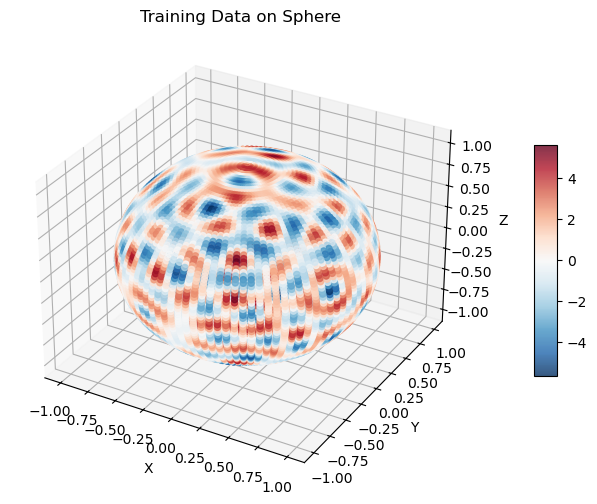

In [7]:
theta_plot, phi_plot = X[:, 0], X[:, 1]

x = np.sin(theta_plot) * np.cos(phi_plot)
y_coords = np.sin(theta_plot) * np.sin(phi_plot)
z = np.cos(theta_plot)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Normalize y_train for color mapping
norm = plt.Normalize(vmin=np.min(y), vmax=np.max(y))
colors = plt.cm.viridis(norm(y))

# Plot the training data
scatter = ax.scatter(
    x, y_coords, z,
    c=y, cmap='RdBu_r', marker='o', s=20, alpha=0.8
)

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10, pad=0.1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Training Data on Sphere')

# Show the plot
plt.show()

In [15]:
num_epochs = 500
Q = 2
depth=20
L0=10

spherical_siren = SphericalSiren(L0 = L0, Q = Q, hidden_features = depth, out_features = 1, activation = torch.sin)
# X, y = map(lambda x : torch.tensor(x).detach().clone().requires_grad_(True), (X, y))

In [9]:
print("Reachable L = K^(Q-1) x L_0 = ", 2**(Q-1) * L0)

Reachable L = K^(Q-1) x L_0 =  40


In [16]:
optimizer = optim.Adam(spherical_siren.parameters(), lr=1e-1)

spherical_siren.train()
for epoch in range(num_epochs):

    outputs = spherical_siren(X).squeeze()
    loss = (outputs - y).pow(2).mean(axis = 0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}', end = '\r')

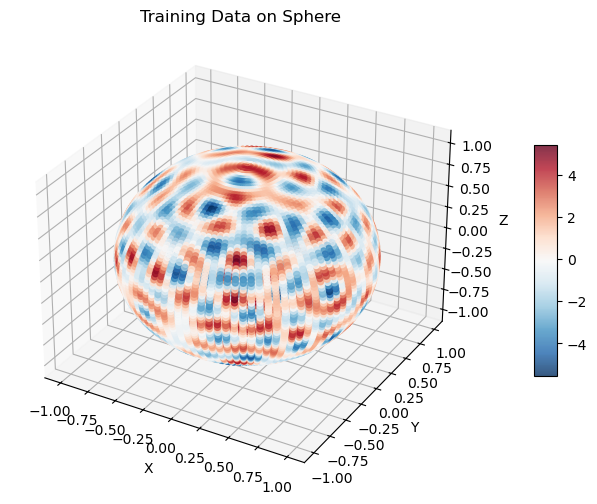

In [17]:
theta_plot, phi_plot = X[:, 0].clone().detach().numpy(), X[:, 1].clone().detach().numpy()
y_plot = spherical_siren(X).squeeze().detach().numpy()

x = np.sin(theta_plot) * np.cos(phi_plot)
y_coords = np.sin(theta_plot) * np.sin(phi_plot)
z = np.cos(theta_plot)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Normalize y_train for color mapping
norm = plt.Normalize(vmin=np.min(y_plot), vmax=np.max(y_plot))
colors = plt.cm.viridis(norm(y_plot))

# Plot the training data
scatter = ax.scatter(
    x, y_coords, z,
    c=y_plot, cmap='RdBu_r', marker='o', s=20, alpha=0.8
)

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10, pad=0.1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Training Data on Sphere')

# Show the plot
plt.show()

In [20]:
inside = spherical_siren.forward_inside(X)